# Art Auction Data Analysis


#### Potential Data Sources:

1. Sotheby's Institute of Art website's E-Resources section lists a few online Price Databases: http://nylibrary.sothebysinstitute.com/rr_eresources_pricedb.html
2. askART - An online database containing close to 300,000 artists with information ranging from biographies to auction records: http://www.askart.com/
3. artprice - An online source of art market information. It is also a market place for buying and selling artworks: http://www.artprice.com/
4. **Blouin Art Sales Index** (listed on Sotheby's Institute of Art websites' E-Resources section) - This Art Sales Index online database includes over 255,000 artists and 350 auction houses. On this website 5 million auction sale results for paintings, watercolors, drawings, sculptures, and selected prints and photographs from 1922 to the present are listed and can be searched for free.: http://artsalesindex.artinfo.com/asi/security/landing-page.ai
---

**Data Collection**

Scraping data from the **Blouin Art Sales Index** website: The website lists Artists alphabetically. Each alphabet result has multiple pages. The rudimentary web scraping function scrapes only the first page results for each alphabet. The function first extracts individual artists url. Then next paintings url for each artist in artist url list (again, this collects only first page results of paintings listing by each artist) are iteratively extracted. And finally painting information from each painting url is extracted iteratively.

- **Some scraping statistics**
    - Number of Artists Data Scraped: 3900
    - Number of Paintings Data Scraped: 11408
    

- **Features in the collected data**
    - Artist Name
    - Artist Country
    - Artist Birth Year
    - Artist Death Year
    - Painting Name
    - Painting Year
    - Painting Price
    - Painting Material
    - Painting Height
    - Painting Width
---
**Data Cleaning**

- Removed: ',' and other characters from numeric columns
- Removed: digits/numbers from string colums
- Filtered data if price data was not available

---
**Exploratory Data Analysis & Feature Engineering**

- Developed histograms (with and without: log transformation and z-score normalization) of:
    - Price of painting 
    - Height of painting 
    - Width of painting 
    - Area of painting - Feature engineering 
       
- Developed joint distribution plots (with and without: log transformation and z-score normalization) of:
    - Price of painting 
    - Height of painting 
    - Width of painting 
    - Area of painting - Feature engineering 
       
- Grouped by Country, Artists and calculate average price of paintings.

---

In [196]:
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import urllib2
import requests
import re
import httplib

import datetime as dt

In [153]:
# Function to collect artist urls based on artist name albhabet (first page results only!)
# Need to update function to visit all alphabet pages
def collect_artist_urls(letter):
    '''
    Needs a string: an english alphabet or letter in capitals, e.g. K
    '''
    main_url = 'http://artsalesindex.artinfo.com/asi/search/artistsAtoZ.ai?lastName=' + letter
    html = urllib2.urlopen(main_url)
    bsObj = BeautifulSoup(html)

    # Empty list to store each artists url
    artist_urls = []
    base_url = 'http://artsalesindex.artinfo.com/'
    # Find all 'td' tags in the beautifulsoup object
    for t in bsObj.findAll('td'):
        # Find all 'a' tags inside each 'td' tags
        for a in t.findAll('a'):
            url_str = base_url + a.get('href') # Some url's have space
            url_str = url_str.replace(' ', '_') # Remove space from url string
            #print url_str
            artist_urls.append(url_str) # Append to artist urls list
    return artist_urls

In [190]:
painting_base_url = 'http://artsalesindex.artinfo.com/asi/'
painting_urls = []
for a_url in artist_url_list:
    try:
        p_html = urllib2.urlopen(a_url)
        p_bsObj = BeautifulSoup(p_html)
        # Find all 'div' tags with 'class' = 'image'
        p_url = p_bsObj.findAll('div', {'class':'image'})
        # For each painting get painting url
        for p in p_url:
            for a in p.findAll('a'):
                painting_urls.append(painting_base_url + a.get('href'))
    except (urllib2.HTTPError, httplib.HTTPException): # Catch HTTP Error, BadStatusLine and continue
        continue

In [158]:
artists = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 
           'R', 'S', 'T', 'U', 'V', 'W', 'W', 'Y', 'Z']

artistURL = []

for letter in artists:
    artistURL.append(collect_artist_urls(artist))
    
# Making a flat list out of lists of list
artist_url_list = reduce(lambda x,y: x + y, artistURL)
print 'Number of artists links collected: {}'.format(len(artist_url_list))   

In [199]:
## Data collecting now
artist = [] 
country = [] 
birth_year = [] 
death_year = [] 
painting_name = [] 
year = [] 
price = [] 
material = []  
height = [] 
width = [] 


start = dt.datetime.now()

# Define and compile a regular expression pattern
pattern = re.compile('^\s+|\s*,\s*|\s+$—') # \s matches any whitespace char

# Loop over all the collected painting urls and scrape information
for i, url in enumerate(painting_urls):
    try:
        html = urllib2.urlopen(url)
        bsObj = BeautifulSoup(html)
    
        ## Extract artist: name
        artist_name = bsObj.find('input', {'id':'artistName'})
        artist_name = artist_name.get('value')
        artist.append(artist_name.strip()) # Strip extra spacing before and after name
    
        ## Get artist info: country, birth year, death year
        artist_info = bsObj.find('p', {'class':'artist-nationality'}).text
        artist_info = artist_info.split() # Split string into a list
        artist_info = ''.join(artist_info) # Concatenate all list items
        artist_info = artist_info.strip('()') # Remove '(' and ')' from string
        if len(artist_info) == 0: # Case: If no info
            country.append('')
            birth_year.append('')
            death_year.append('')
        else: # Case: If info 
            artist_info = artist_info.replace('-', ',') 
            temp = pattern.split(artist_info) # Split string by occurrences of defined pattern and return a list
            # Extract artist: country, birth year, death year
            if len(temp) == 1: # Only country available
                country.append(temp[0])
                birth_year.append('')
                death_year.append('')
            elif len(temp) == 2: # Only country, birth year available
                country.append(temp[0])
                birth_year.append(temp[1])
                death_year.append('')
            elif len(temp) == 3: # All available
                country.append(temp[0])
                birth_year.append(temp[1])
                death_year.append(temp[1])
            else: 
                country.append('')
                birth_year.append('')
                death_year.append('')
            
            ## Extract painting name 
            p_name = bsObj.find('h4', {'class':'title'}).text
            painting_name.append(p_name)
    
            ## Extract painting year
            p_year = bsObj.find('div', {'id':'artworkIndex_0'})
            p_year = p_year.findAll('p')[1].text
            year.append(p_year.strip()) # Strip extra spacing before and after
            #print bsObj.find('div', {'id':'artworkIndex_0'}).findAll('p')
    
        ## Extract price
        p_price = bsObj.find('div', {'class':'price'}).text
        p_price = p_price.split()
        if len(p_price) > 3: # price of paintings that are not bought in
            price.append(p_price[1]) # index of price digits in list = 1
        else:
            price.append('')
    
        ## Get painting details: material, size, markings, condition, etc.
        p_details = bsObj.findAll('p', {'class':'artworkdetails'}) # list of painting details
    
        ## Extract painting material
        p_material = p_details[0].text
        p_material = p_material.split()[1] # split string into a list and get 1st item

        ## Extract painting size
        p_size = p_details[1].text
        p_size = p_size.split() # split string into a list 
        if len(p_size) == 12:
            height.append(p_size[1]) # height in inches is 1st item in the list
            width.append(p_size[7]) # width in inches is 7th item in the list
            #print p_size, len(p_size)
    except (urllib2.HTTPError, httplib.HTTPException): # Catch HTTP Error, BadStatusLine and continue
        continue
    
    print 'Url: {} and Seconds: {}'.format(i, (dt.datetime.now() - start).seconds)

Url: 0 and Seconds: 0
Url: 1 and Seconds: 0
Url: 2 and Seconds: 1
Url: 3 and Seconds: 1
Url: 4 and Seconds: 1
Url: 5 and Seconds: 2
Url: 6 and Seconds: 2
Url: 7 and Seconds: 2
Url: 8 and Seconds: 3
Url: 9 and Seconds: 3
Url: 10 and Seconds: 3
Url: 11 and Seconds: 4
Url: 12 and Seconds: 4
Url: 13 and Seconds: 4
Url: 14 and Seconds: 5
Url: 15 and Seconds: 5
Url: 16 and Seconds: 6
Url: 17 and Seconds: 6
Url: 18 and Seconds: 6
Url: 19 and Seconds: 7
Url: 20 and Seconds: 7
Url: 21 and Seconds: 7
Url: 22 and Seconds: 8
Url: 23 and Seconds: 8
Url: 24 and Seconds: 8
Url: 25 and Seconds: 9
Url: 26 and Seconds: 9
Url: 27 and Seconds: 9
Url: 28 and Seconds: 10
Url: 29 and Seconds: 10
Url: 30 and Seconds: 10
Url: 31 and Seconds: 11
Url: 32 and Seconds: 11
Url: 33 and Seconds: 12
Url: 34 and Seconds: 12
Url: 35 and Seconds: 12
Url: 36 and Seconds: 13
Url: 37 and Seconds: 13
Url: 38 and Seconds: 13
Url: 39 and Seconds: 14
Url: 40 and Seconds: 14
Url: 41 and Seconds: 14
Url: 42 and Seconds: 15
Url: 4

In [207]:
# Create a Pandas Dataframe using scraping output
scraped_data = pd.DataFrame(data = [artist, country, birth_year, death_year, painting_name, year, price, material, height, width])
scraped_data.head(3)
# Transpose dataframe
scraped_data = scraped_data.T
scraped_data.head(3)
# Assign column names to columns
scraped_data.columns = ['artist', 'country', 'birth_year', 'death_year', 'painting_name', 'year', 'price', 'material', 'height', 'width']
# Write data to csv
scraped_data.to_csv('artist_data.csv', encoding='utf-8')
scraped_data.head(3)

,artist,country,birth_year,death_year,painting_name,year,price,material,height,width
0,Attributed to Ya Chen,Chinese,20thC,,Carp and seagrasses,,649,None,12.00,15.75
1,Ya Gong,Chinese,19thC,,A lady in a red hat standing under a snowy tree,1877,601,None,35.00,13.00
2,Ya Ming,Chinese,1924,1924,Mountains in the Mist,1979,"11,287",None,27.36,18.03


## Exploratory Data Analysis

In [210]:
# Remove outliers
data = scraped_data[scraped_data['price'] != '']
data = data.reset_index(drop = True)
print data.shape

(7596, 10)

In [213]:
# Remove ',' from price and convert str to float
data['price'] = data['price'].str.replace(',', '')
data['price'] = data['price'].astype(float)

In [295]:
# Convert height and width str to float
data['height'] = data['height'].astype(float)
data['width'] = data['width'].astype(float)

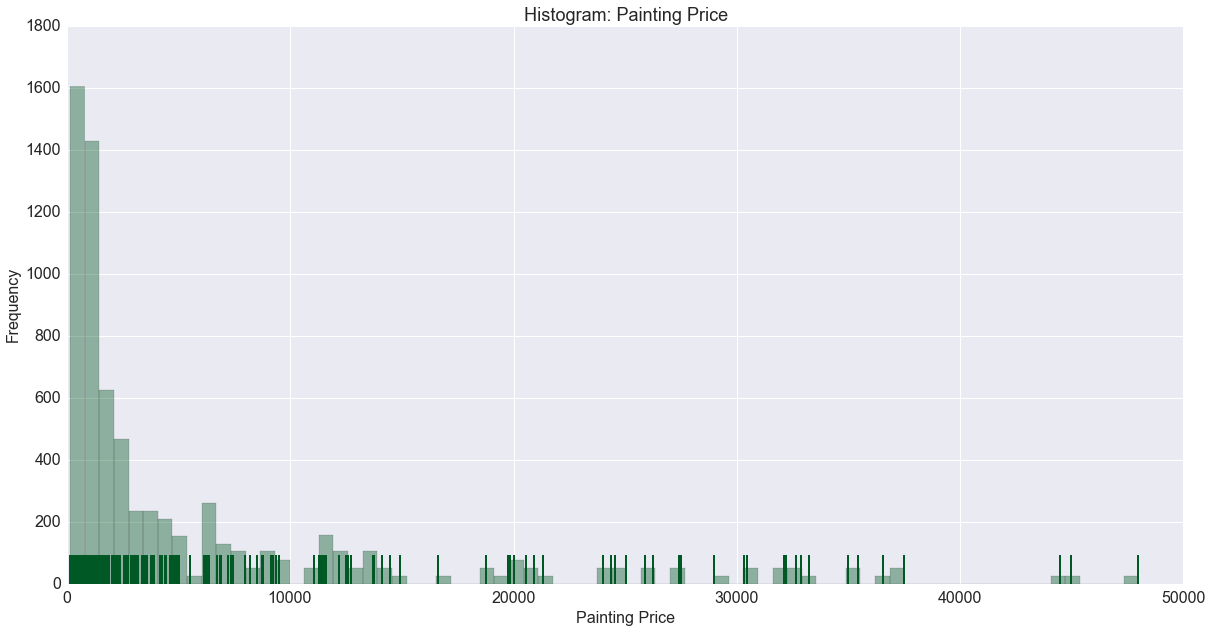

In [218]:
# Histogram: Price
temp = data[['price']] 
temp = temp[temp['price'] < 50000]

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#005824')
plt.xlabel('Painting Price', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Painting Price', fontsize = 18)

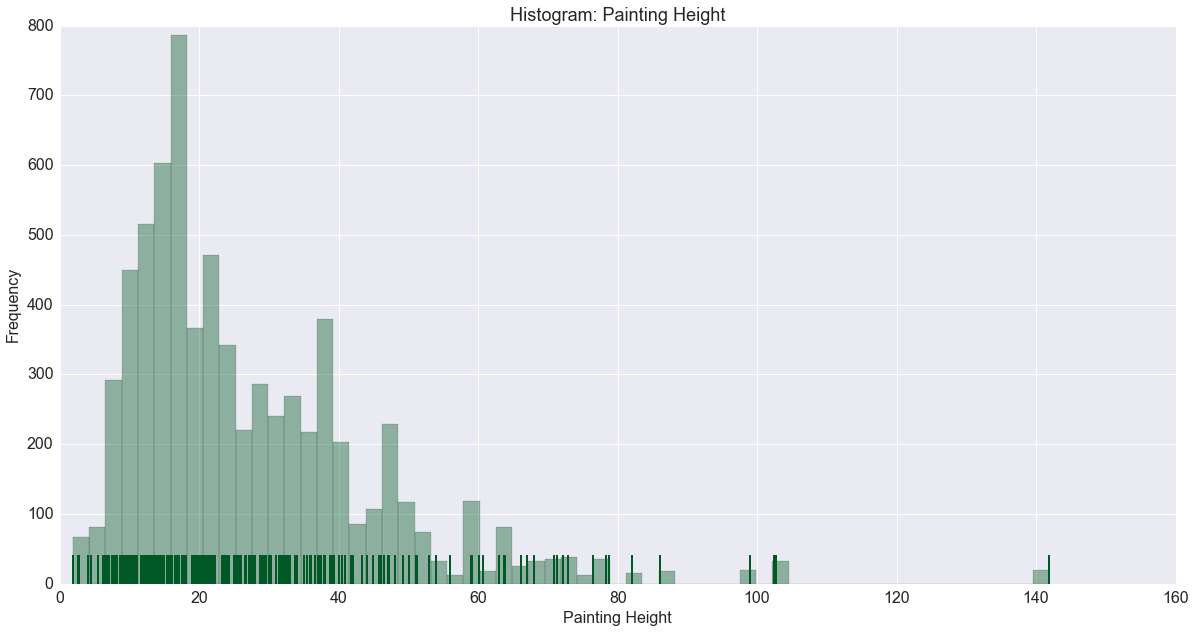

In [221]:
# Histogram: height
temp = data[['height']] 
temp = temp[temp['height'] < 150] # Removing outliers
plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#005824')
plt.xlabel('Painting Height', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Painting Height', fontsize = 18)

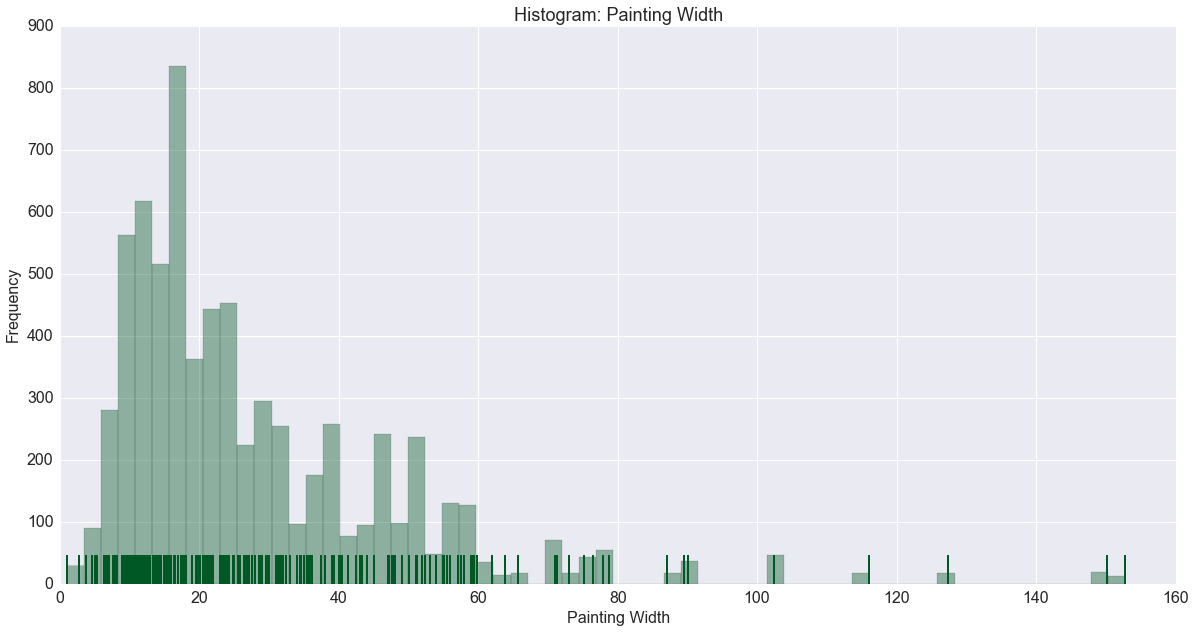

In [223]:
# Histogram: width
temp = data[['width']] 
temp = temp[temp['width'] < 200] # Removing outliers
plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#005824')
plt.xlabel('Painting Width', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Painting Width', fontsize = 18)

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead


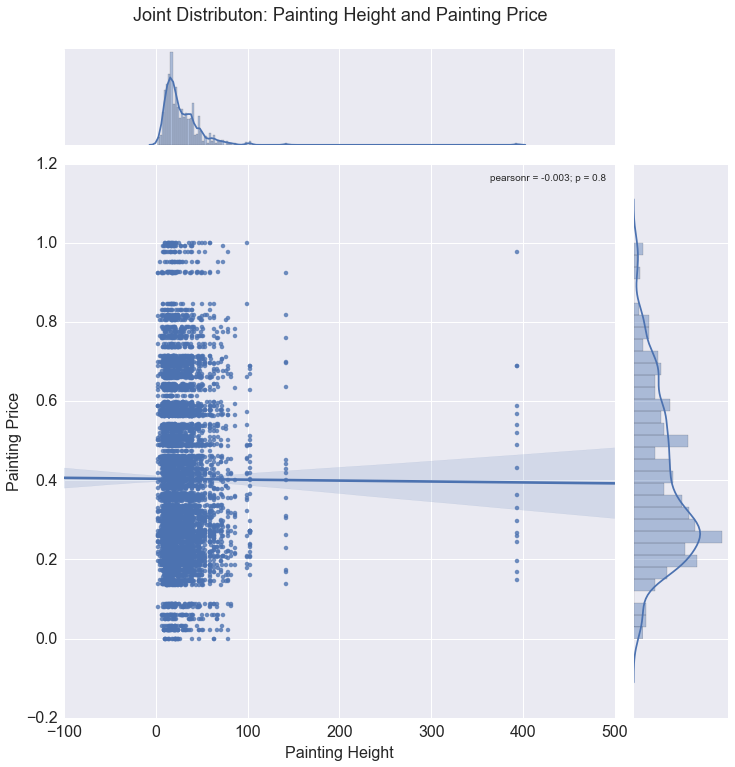

In [227]:
# Joint Distribution: Height and Price (log scaled)
temp = data[['price', 'height']]
#temp = temp[(temp['Annual_ResPPD_2013'] < 20) & (temp['Fam_Income_Ratio'] < 100)] # Dropped outliers and infinity

# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)

temp['price'] = temp['price'].apply(lambda x: (np.log(x) - np.log(temp['price'].min()))/(np.log(temp['price'].max()) - np.log(temp['price'].min())))

sns.jointplot('height', 'price', data = temp, kind = 'reg', size = 10)
plt.xlabel('Painting Height', fontsize = 16)
plt.ylabel('Painting Price', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Painting Height and Painting Price'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

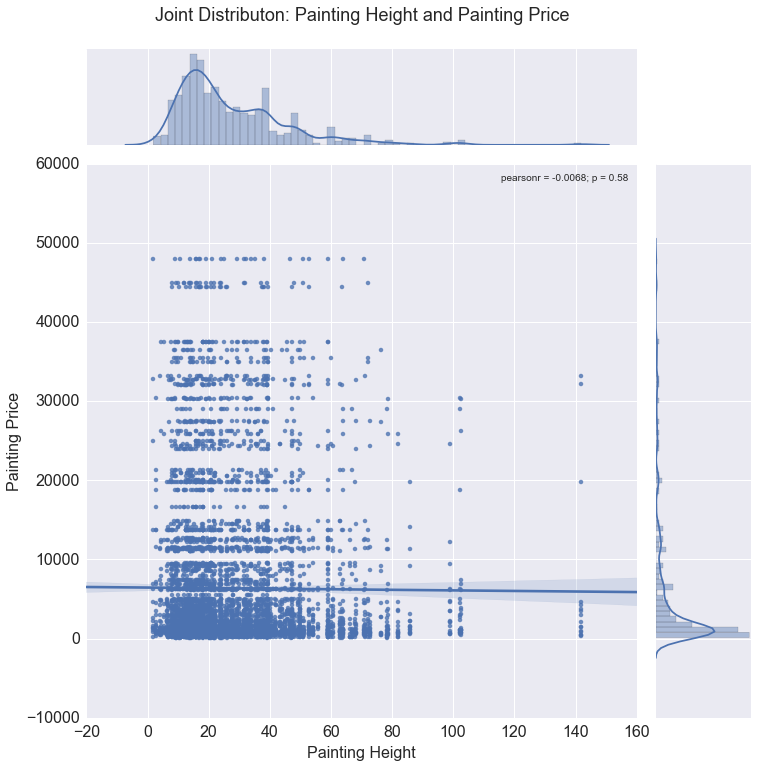

In [230]:
# Joint Distribution: Height and Price
temp = data[['price', 'height']]
temp = temp[(temp['price'] < 50000) & (temp['height'] < 150)] # Dropped outliers 
# z-score Normalize
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
#temp['price'] = temp['price'].apply(lambda x: (np.log(x) - np.log(temp['price'].min()))/(np.log(temp['price'].max()) - np.log(temp['price'].min())))
sns.jointplot('height', 'price', data = temp, kind = 'reg', size = 10)
plt.xlabel('Painting Height', fontsize = 16)
plt.ylabel('Painting Price', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Painting Height and Painting Price'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

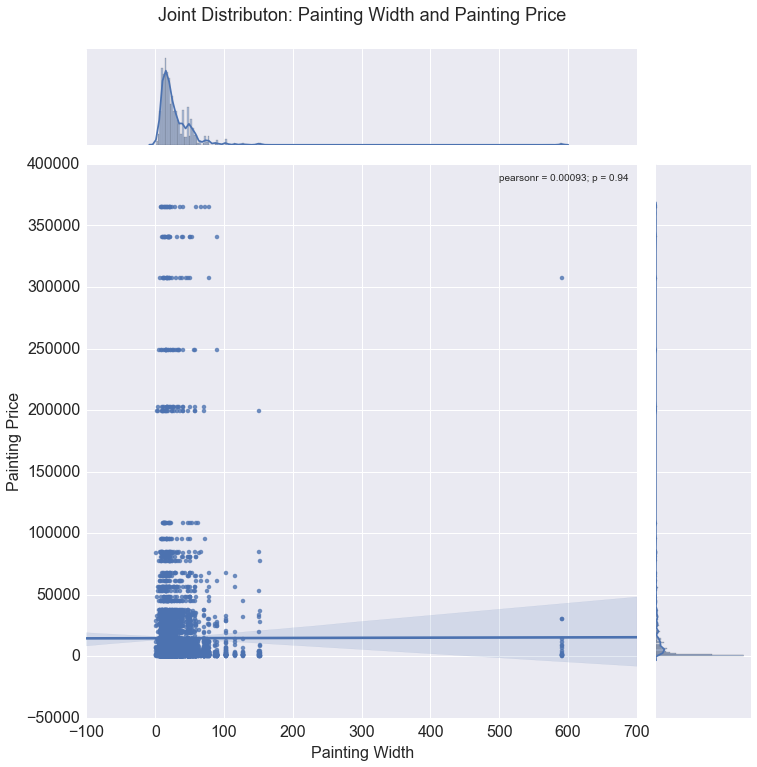

In [229]:
# Joint Distribution: Weight and Price
temp = data[['price', 'width']]
#temp = temp[(temp['Annual_ResPPD_2013'] < 20) & (temp['Fam_Income_Ratio'] < 100)] # Dropped outliers and infinity
# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
#temp['price'] = temp['price'].apply(lambda x: (np.log(x) - np.log(temp['price'].min()))/(np.log(temp['price'].max()) - np.log(temp['price'].min())))
sns.jointplot('width', 'price', data = temp, kind = 'reg', size = 10)
plt.xlabel('Painting Width', fontsize = 16)
plt.ylabel('Painting Price', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Painting Width and Painting Price'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

In [296]:
# Create a new feature: Painting area
data['area'] = data['height'] * data['width']

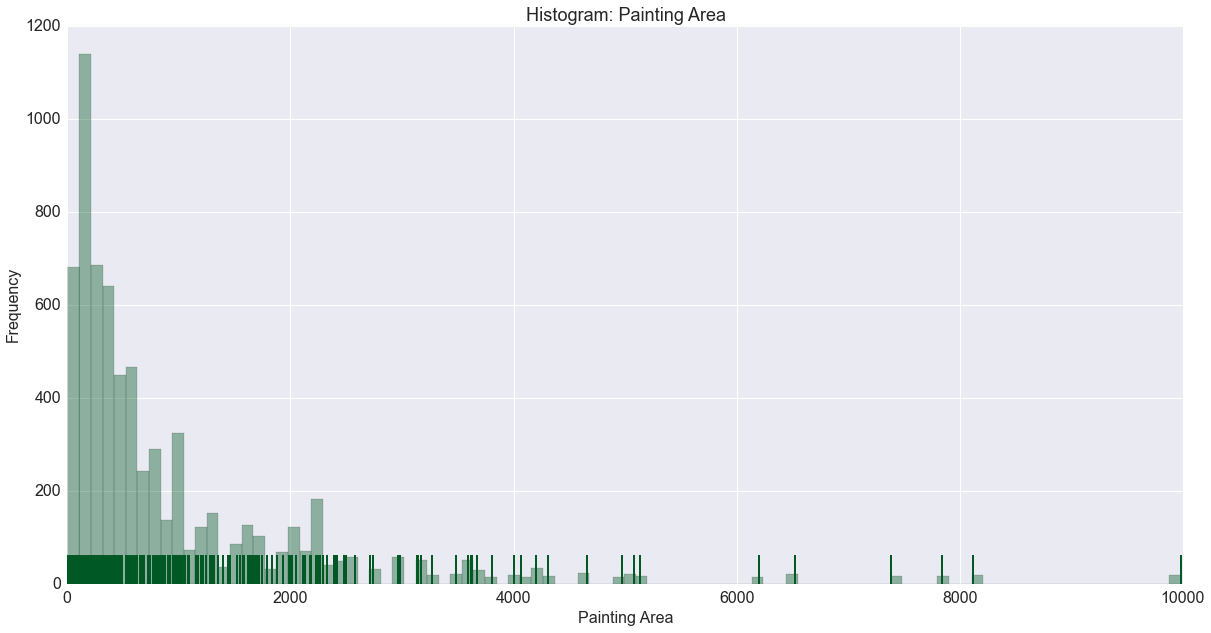

In [234]:
# Histogram: painting area
temp = data[['area']] 
temp = temp[temp['area'] < 10000] # Removing outliers
plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#005824')
plt.xlabel('Painting Area', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Painting Area', fontsize = 18)

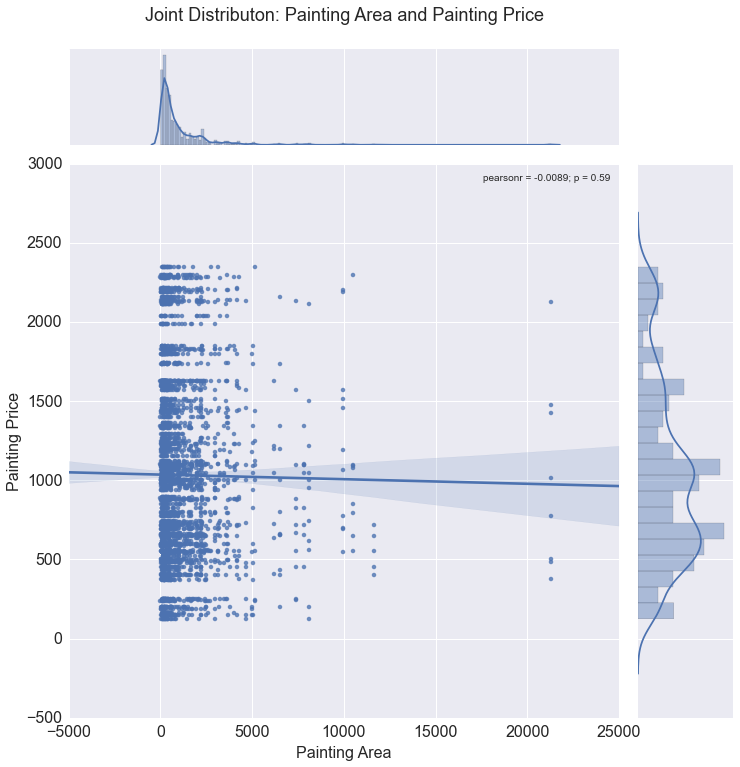

In [240]:
# Joint Distribution: Area and Price
temp = data[['price', 'area']]
temp = temp[(temp['area'] < 50000) & (temp['price'] < 2500)] # Dropped outliers and infinity
# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
#temp['price'] = temp['price'].apply(lambda x: (np.log(x) - np.log(temp['price'].min()))/(np.log(temp['price'].max()) - np.log(temp['price'].min())))
sns.jointplot('area', 'price', data = temp, kind = 'reg', size = 10)
plt.xlabel('Painting Area', fontsize = 16)
plt.ylabel('Painting Price', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Painting Area and Painting Price'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

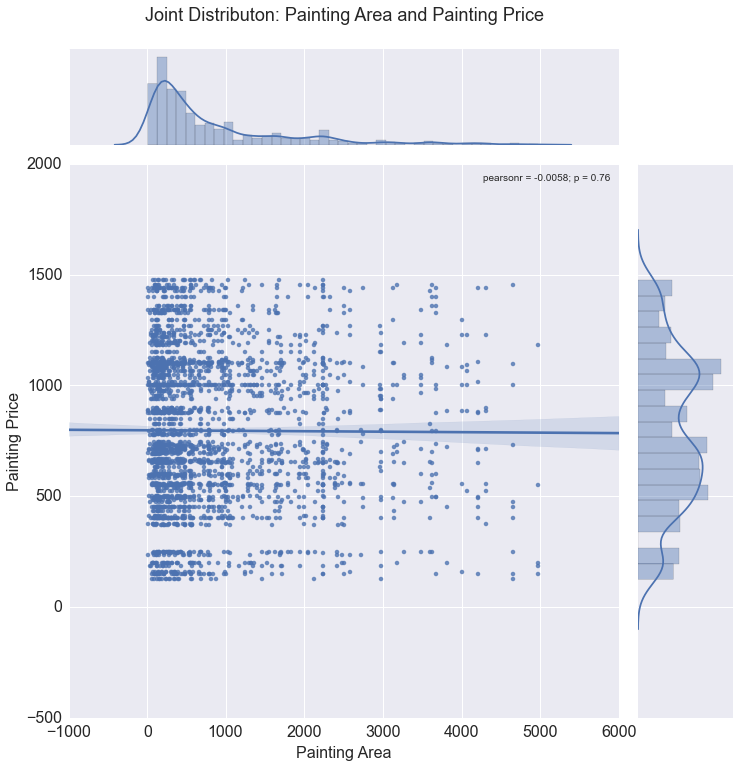

In [241]:
# Joint Distribution: Area and Price
temp = data[['price', 'area']]
temp = temp[(temp['area'] < 5000) & (temp['price'] < 1500)] # Dropped outliers and infinity
# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
#temp['price'] = temp['price'].apply(lambda x: (np.log(x) - np.log(temp['price'].min()))/(np.log(temp['price'].max()) - np.log(temp['price'].min())))
sns.jointplot('area', 'price', data = temp, kind = 'reg', size = 10)
plt.xlabel('Painting Area', fontsize = 16)
plt.ylabel('Painting Price', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Painting Area and Painting Price'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

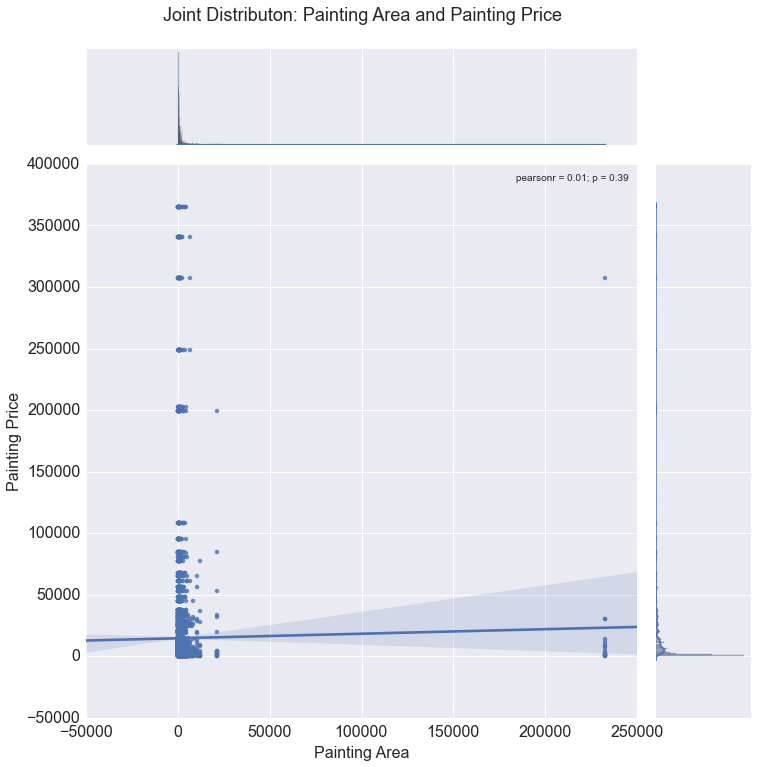

In [242]:
# Joint Distribution: Area and Price
temp = data[['price', 'area']]
#temp = temp[(temp['area'] < 50000) & (temp['price'] < 2500)] # Dropped outliers and infinity
# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
#temp['price'] = temp['price'].apply(lambda x: (np.log(x) - np.log(temp['price'].min()))/(np.log(temp['price'].max()) - np.log(temp['price'].min())))
sns.jointplot('area', 'price', data = temp, kind = 'reg', size = 10)
plt.xlabel('Painting Area', fontsize = 16)
plt.ylabel('Painting Price', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Painting Area and Painting Price'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')

In [247]:
# Cleaning country column
# Check if country has NaN value
temp = data[data['country'].isnull() == True]
temp.shape[0] # No NaN

0

In [253]:
## Remove digits/numeric values from country column
countries = []
for i in range(data.shape[0]):
    country_list = data['country'].tolist()
    if country_list[i].isalpha() == True: # Check if country names is alphabetic
        countries.append(country_list[i])

print 'Number of rows with number in their names: {}'.format(data.shape[0]-len(countries))

Number of rows with number in their names: 542


- price/country
- price/year

In [254]:
# Remove countries with number in their names
data = data[data['country'].isin(countries)]
data.shape

(7054, 11)

In [257]:
# Cleaning material column
data.tail()

,artist,country,birth_year,death_year,painting_name,year,price,material,height,width,area
7591,Taro Yamamoto,American,1919,1919,None,None,615,None,NaN,NaN,NaN
7592,Taro Yamamoto,American,1919,1919,None,None,550,None,NaN,NaN,NaN
7593,Taro Yamamoto,American,1919,1919,None,None,1800,None,NaN,NaN,NaN
7594,Taro Yamamoto,American,1919,1919,None,None,2214,None,NaN,NaN,NaN
7595,Taro Yamamoto,American,1919,1919,None,None,554,None,NaN,NaN,NaN


In [267]:
# Get average price per country
price_per_country = data.groupby(['country'])[['price']].mean()
price_per_country.reset_index(inplace = True)
price_per_country.to_csv('avgPricePerCountry.csv')

In [269]:
# Remove outliers
data = scraped_data[scraped_data['price'] != '']
data = data.reset_index(drop = True)
print data.shape
# Remove ',' from price and convert str to float
data['price'] = data['price'].str.replace(',', '')
data['price'] = data['price'].astype(float)

(7596, 10)


In [275]:
## Remove alphabetic values from year column
years = []
for i in range(data.shape[0]):
    year_list = data['year'].tolist()
    try:
        if year_list[i].isdigit() == False: # Check if year numeric
            years.append(year_list[i])
    except AttributeError:
        continue

print 'Number of rows with alphabet in their names: {}'.format(data.shape[0]-len(years))

Number of rows with alphabet in their names: 4078


In [276]:
temp = data = data[data['year'].isin(years)]
temp.head()

,artist,country,birth_year,death_year,painting_name,year,price,material,height,width
0,Attributed to Ya Chen,Chinese,20thC,,Carp and seagrasses,,649,None,12.00,15.75
3,Ya Ming,Chinese,1924,1924,River Landscape,,875,None,15.75,78.74
5,Ya Ming,Chinese,1924,1924,View of Tunxi,,13695,None,12.72,17.36
10,Najaf Ya Shah,Persian,13thC,,Untitled,,6368,None,55.91,23.23
12,Ya Shaosong,Chinese,1882,1882,Mae West,,3172,None,10.50,15.25


In [290]:
from math import log
data['logPrice'] = data['price'].apply(lambda p: log(p))

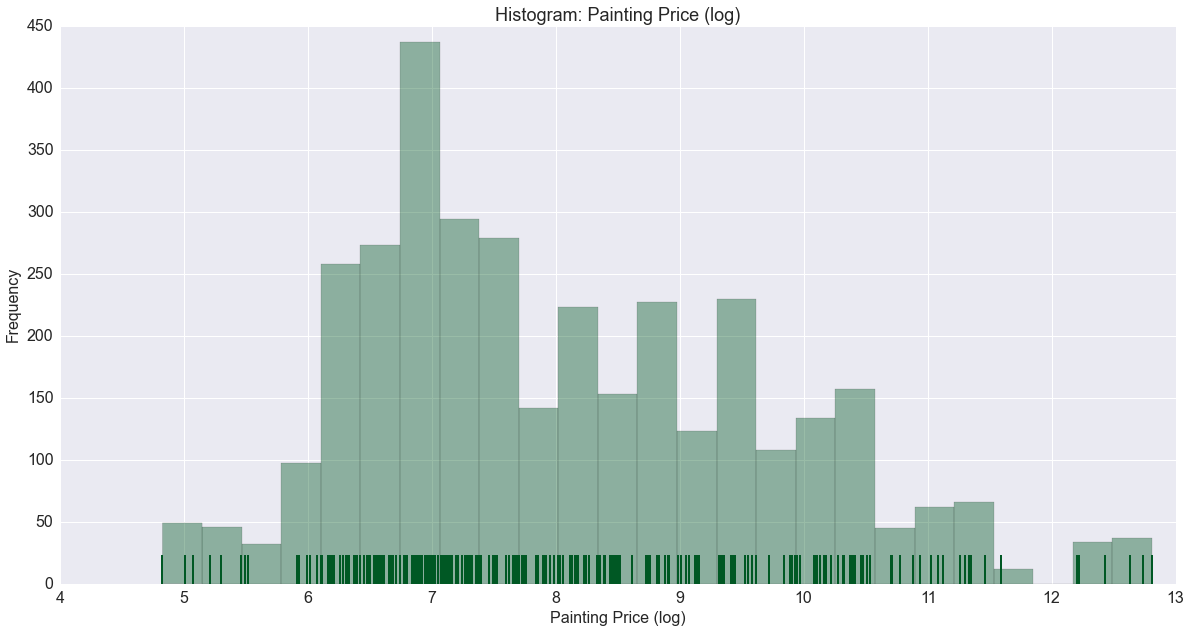

In [292]:
# Histogram: Log Price
temp = data[['logPrice']] 
#temp = temp[temp['price'] < 50000]

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#005824')
plt.xlabel('Painting Price (log)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Painting Price (log)', fontsize = 18)

In [297]:
data['logArea'] = data['area'].apply(lambda a: log(a))

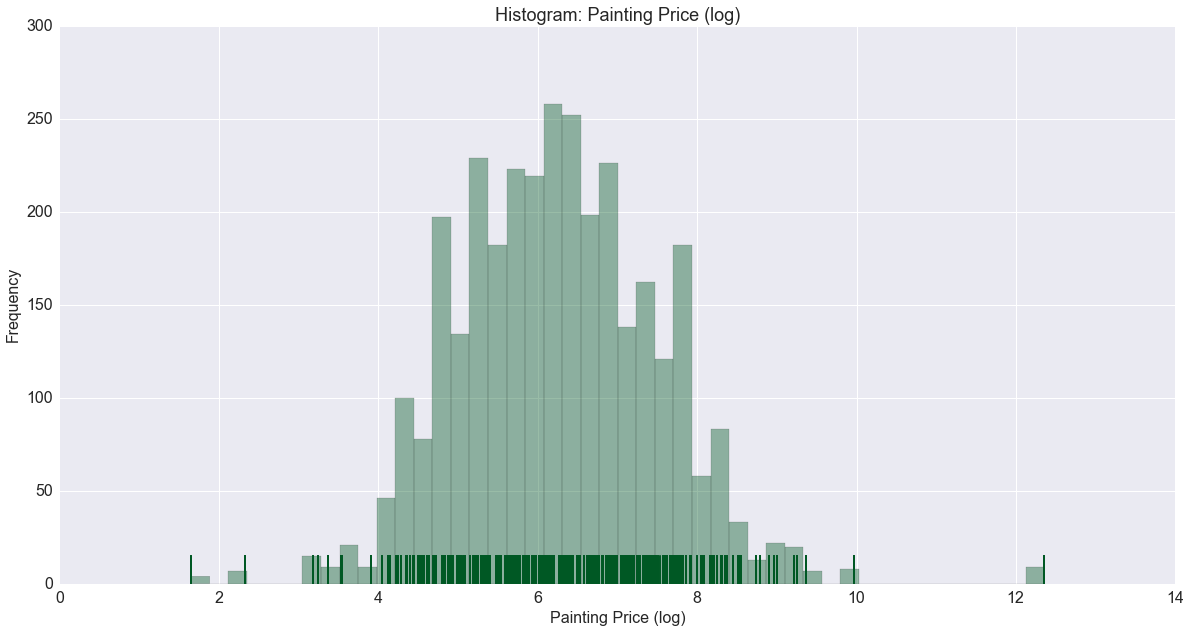

In [298]:
# Histogram: Log area
temp = data[['logArea']] 
#temp = temp[temp['price'] < 50000]

plt.figure(figsize = (20, 10))
sns.distplot(temp.dropna(), kde = False, rug = True, color = '#005824')
plt.xlabel('Painting Price (log)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram: Painting Price (log)', fontsize = 18)

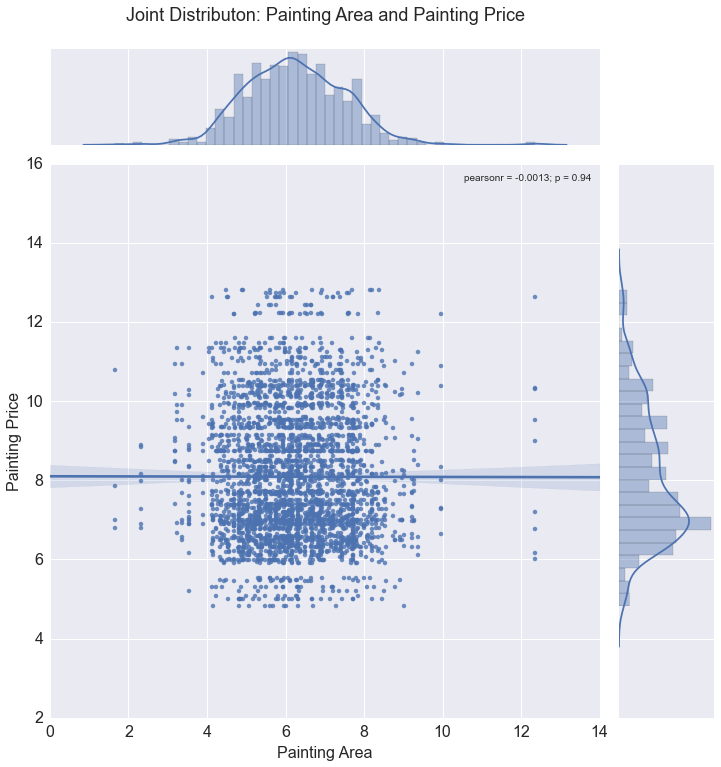

In [299]:
# Joint Distribution: Area and Price
temp = data[['logPrice', 'logArea']]
#temp = temp[(temp['area'] < 50000) & (temp['price'] < 2500)] # Dropped outliers and infinity
# z-score Normalize 
#temp = (temp - temp.mean(axis=0))/temp.std(axis=0)
#temp['price'] = temp['price'].apply(lambda x: (np.log(x) - np.log(temp['price'].min()))/(np.log(temp['price'].max()) - np.log(temp['price'].min())))
sns.jointplot('logArea', 'logPrice', data = temp, kind = 'reg', size = 10)
plt.xlabel('Painting Area', fontsize = 16)
plt.ylabel('Painting Price', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# Set vertical position of title using argument y
text = 'Joint Distributon: Painting Area (log) and Painting Price (log)'
plt.title(text, fontsize = 18, y = 1.25, horizontalalignment='center')